# Camera calibration

In this article is presented a method to obtain the intrinsic parameters of a real camera.

## Basics

### Camera intrinsics

$$K=
\begin{bmatrix}
f_x & 0   & c_x \\
0   & f_y & c_y \\
0   & 0   & 1
\end{bmatrix}$$

### Distortion coefficients


$$x_{corrected}=x\begin{pmatrix}1 + k_1r^2 + k_2r^4 + k_3r^6\end{pmatrix}$$

$$y_{corrected}=y\begin{pmatrix}1 + k_1r^2 + k_2r^4 + k_3r^6\end{pmatrix}$$


$$x_{corrected}=x + \begin{bmatrix}2p_1xy + p_2\begin{pmatrix}r^2 + 2x^2\end{pmatrix}\end{bmatrix}$$

$$y_{corrected}=y + \begin{bmatrix}p_1\begin{pmatrix}r^2 + 2y^2\end{pmatrix} + 2p_2xy\end{bmatrix}$$


$$d=
\begin{bmatrix}
k_1 & k_2 & p_1 & p_2 & k_3
\end{bmatrix}$$


## Code

In [1]:
%matplotlib inline
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load images
images = sorted(glob.glob('images/4.2. Camera calibration/captures/frame*.jpg'))

In [3]:
# Compute camera calibration function

# pattern parameters
rows, columns = 6, 11

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(columns-1,rows-1,0)
objp = np.zeros((rows*columns,3), np.float32)
objp[:,:2] = np.mgrid[0:columns,0:rows].T.reshape(-1,2)

def compute_calibration(images, show=False):

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    chessboards = [] # images with chessboard painted

    for fname in images:
        img = cv2.imread(fname)
        img = cv2.transpose(img)
        img = cv2.flip(img, 1)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (columns,rows), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)
            
            # Perform corner subpixel detection
            cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)

            # Show chessboards detected
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.drawChessboardCorners(img, (columns,rows), corners,ret)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            chessboards.append(img)

    # Perform camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    # Compute calibration error
    n = len(objpoints)
    error = 0
    for i in range(n):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error += cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/(len(imgpoints2))
    error /= n

    return error, mtx, dist, chessboards


Number of samples

16

Calibration error

0.0287244252313

Camera matrix

[[  1.43039147e+03   0.00000000e+00   6.36403930e+02]
 [  0.00000000e+00   1.42966307e+03   4.78032706e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Distortion coefficients

[[  2.71918728e-02  -2.30991447e-01  -7.13362835e-05   8.68588435e-04
    5.08921101e-01]]

Set of images



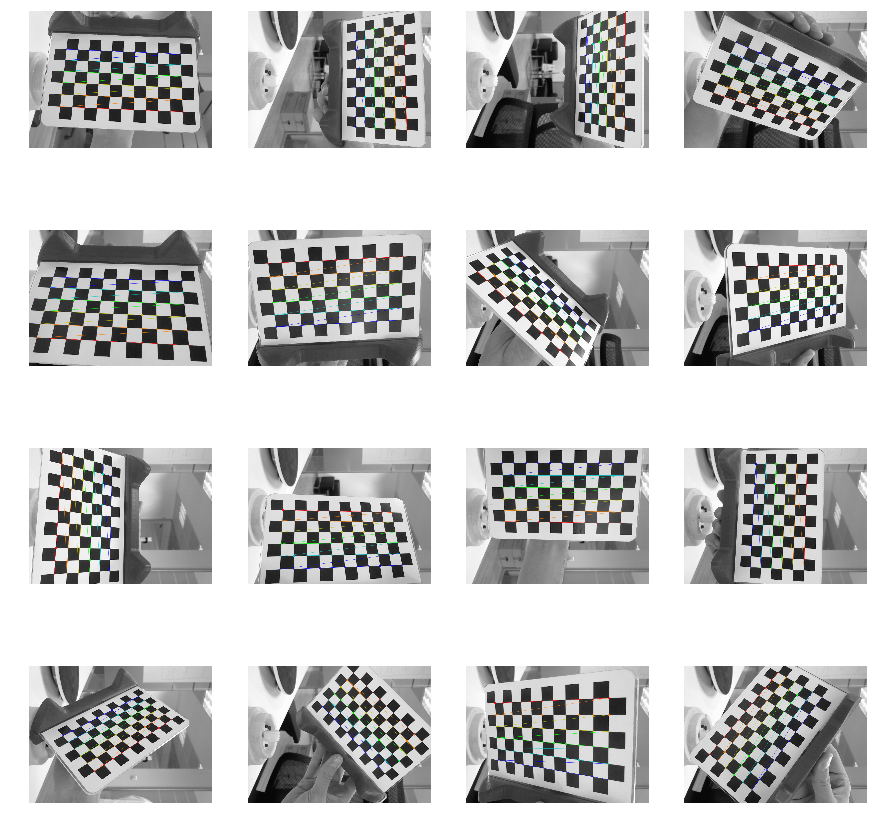

In [4]:
# Compute calibration with all images

error, mtx, dist, chessboards = compute_calibration(images, show=True)

print("\nNumber of samples\n\n{0}".format(len(images)))
print("\nCalibration error\n\n{0}".format(error))
print("\nCamera matrix\n\n{0}".format(mtx))
print("\nDistortion coefficients\n\n{0}".format(dist))
print("\nSet of images\n")
index = 0
x, y = 4, 4
f, axarr = plt.subplots(x, y, figsize=(15,15))
for image in chessboards:
    axarr[index // y, index % y].axis('off')
    axarr[index // y, index % y].imshow(image)
    index += 1

In [5]:
# Compute calibration for 1, 2, 3 ...,n images

error_list = []
mtx_list = []
dist_list = []
index = 2

for i in range(index,len(images)+1):
    error, mtx, dist, _ = compute_calibration(images[:i])
    if error not in [x for _,x in error_list]:
        error_list += [(index, error)]
        mtx_list += [mtx]
        dist_list += [dist]
        index += 1

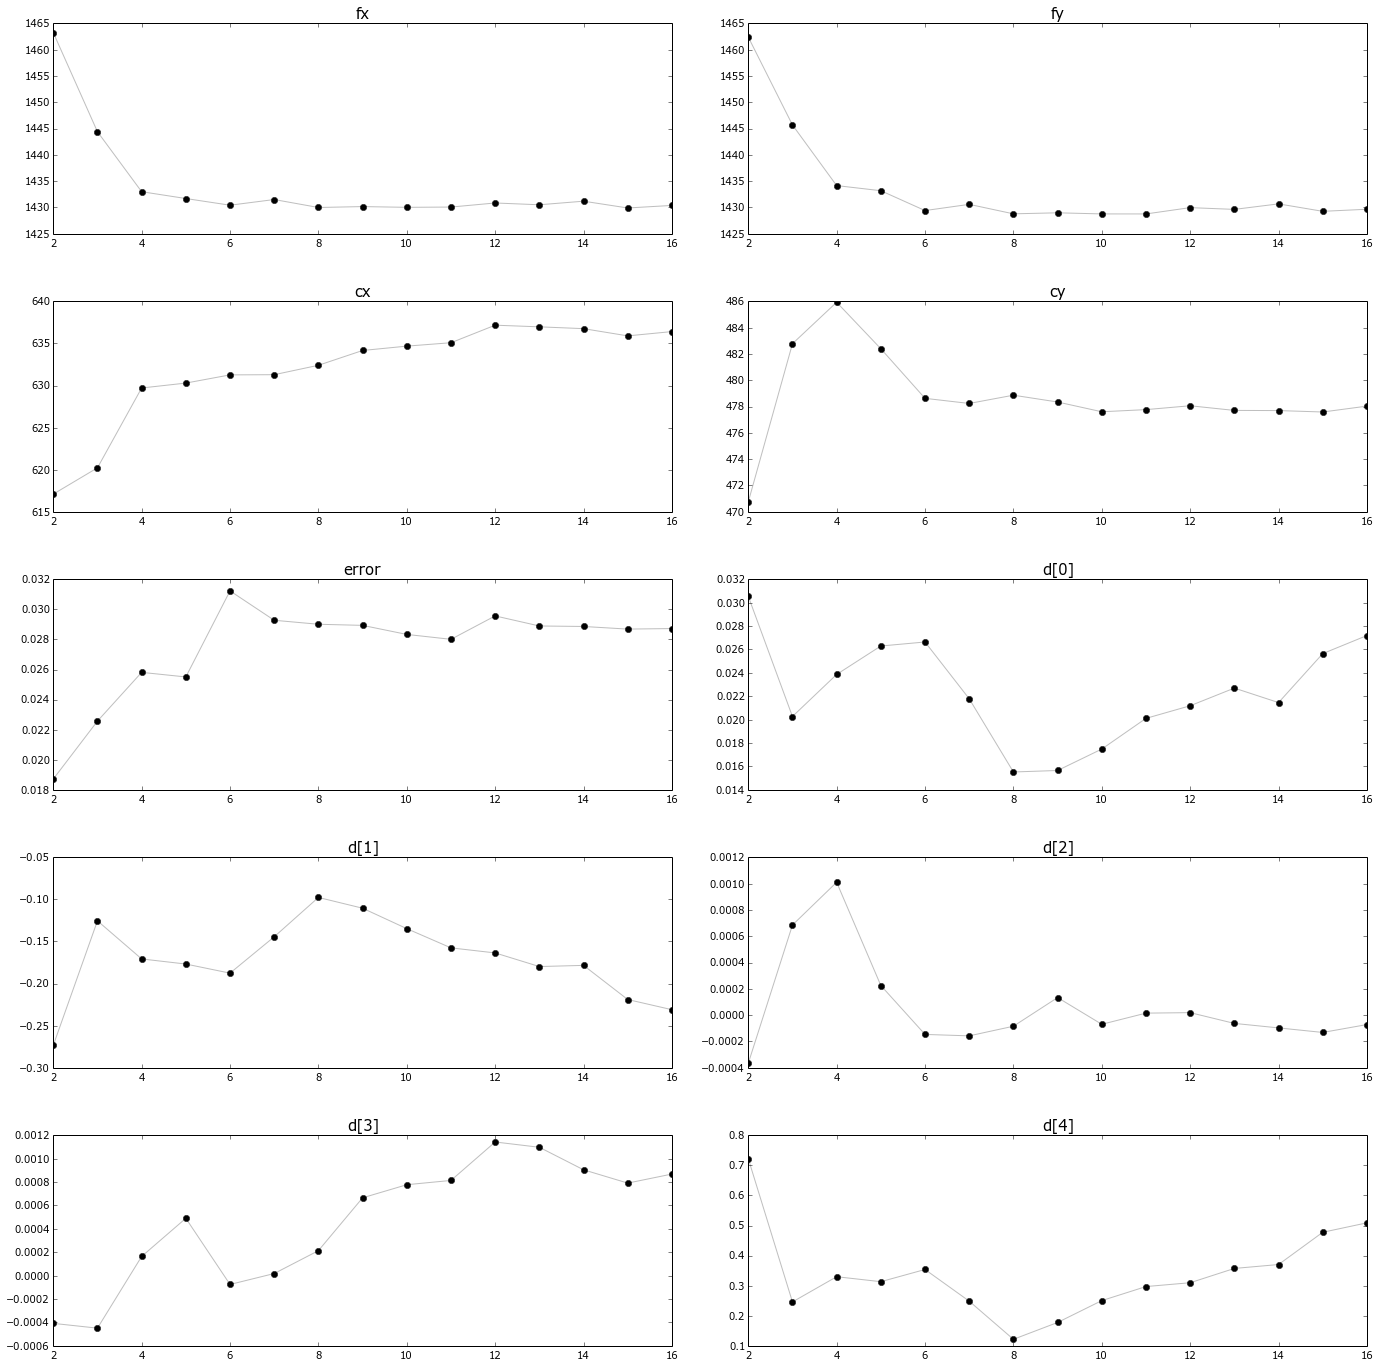

In [6]:
# Plot parameters over number of samples used

x, y = 5, 2
f, axarr = plt.subplots(x, y, figsize=(20,20))
plt.tight_layout(pad=5.0)
def plot(title, list, index):
    axarr[index // y, index % y].set_title(title, size=15)
    axarr[index // y, index % y].plot([x for x,_ in error_list], list, '0.75',
                                      [x for x,_ in error_list], list, 'ko')

plot('fx', [x[0][0] for x in mtx_list], 0)
plot('fy', [x[1][1] for x in mtx_list], 1)
plot('cx', [x[0][2] for x in mtx_list], 2)
plot('cy', [x[1][2] for x in mtx_list], 3)
plot('error', [x for _,x in error_list], 4)
for i in range(5):
    plot('d[{0}]'.format(i), [x[0][i] for x in dist_list], 5+i)

# References
* http://docs.opencv.org/doc/tutorials/calib3d/camera_calibration/camera_calibration.html